# 12: L1 Regularization (Sparse Models)

### 🎯 Objective
This notebook demonstrates how to implement **L1 Regularization**. Unlike L2, which pushes weights to be *small*, L1 pushes weights to be exactly **zero**. This creates **sparse models** and can act as a form of automatic feature selection.

### 📚 Key Concepts
- **L1 Penalty:** Adding $\lambda \sum |w|$ (sum of absolute values) to the loss.
- **Sparsity:** Having many weights equal to zero.
- **Manual Implementation:** Since PyTorch optimizers don't have a built-in `L1` parameter (like `weight_decay` for L2), we must add the penalty term manually during the training loop.

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

## 1. Data Preparation
Standard loading of the Iris dataset.

In [2]:
# import dataset
import seaborn as sns
iris = sns.load_dataset('iris')

In [3]:
# organize the data
data = torch.tensor( iris[iris.columns[0:4]].values ).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [4]:
# split and create dataloaders
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

## 2. Model Construction

Notice that there is **no L1 parameter here**. We just build a standard standard model. The regularization happens in the training loop.

In [5]:
# a function that creates the ANN model
def createANewModel():
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005)

  return ANNiris,lossfun,optimizer

### Inspecting Model Parameters
Before training, let's look at how PyTorch stores parameters. We can iterate through `model.named_parameters()` to access the weights and biases of each layer.

In [6]:
# explore the model in more detail
tmpmodel = createANewModel()[0]

# print the model architecture
print(tmpmodel)

# print the model's parameters
for i in tmpmodel.named_parameters():
  print(i[0],i[1].shape,i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


## 3. Implementing L1 Regularization

This is the critical section. We manually modify the loss function inside the training loop.

**The logic:**
1.  Initialize `L1_term = 0`.
2.  Loop through every parameter in the model.
3.  Sum up the absolute values: `L1_term += torch.sum(torch.abs(weight))`.
4.  Add this term to the loss: `loss = loss + L1lambda * L1_term`.

In [7]:
# train the model
numepochs = 1000

def trainTheModel(L1lambda):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # count the total number of weights in the model
  # We use this to normalize the L1 term so it isn't huge
  nweights = 0
  for pname,weight in ANNiris.named_parameters():
    if 'bias' not in pname:
      nweights = nweights + weight.numel()


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      ### --- MANUAL L1 IMPLEMENTATION --- ###
      L1_term = torch.tensor(0.,requires_grad=True)

      # sum up all abs(weights)
      for pname,weight in ANNiris.named_parameters():
        if 'bias' not in pname:
           L1_term = L1_term + torch.sum(torch.abs(weight))

      # add to loss term
      # We divide by nweights to keep the scale reasonable
      loss = loss + L1lambda*L1_term/nweights
      ### -------------------------------- ###

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # average training accuracy and loss
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader))
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  return trainAcc,testAcc,losses

## 4. Test Run (Small Lambda)
Testing the implementation with a small penalty.

In [8]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
L1lambda = .001
trainAcc,testAcc,losses = trainTheModel(L1lambda)

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1986542055.py:8: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))
/tmp/ipython-input-1986542055.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))


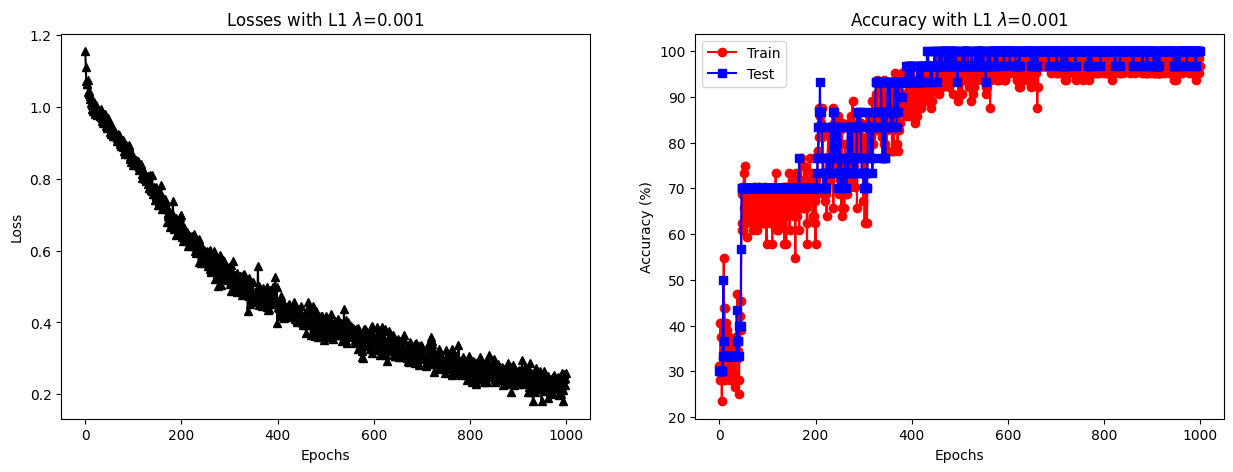

In [9]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [10]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

## 5. The Experiment: Varying L1 Strength

We compare 10 different values of `L1lambda`. As before, we expect performance to drop if the regularization is too strong.

In [11]:
# range of L1 regularization amounts
L1lambda = np.linspace(0,.005,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(L1lambda)))
accuracyResultsTest  = np.zeros((numepochs,len(L1lambda)))


# loop over lambda values
for li in range(len(L1lambda)):

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel()
  trainAcc,testAcc,losses = trainTheModel(L1lambda[li])

  # store data
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)

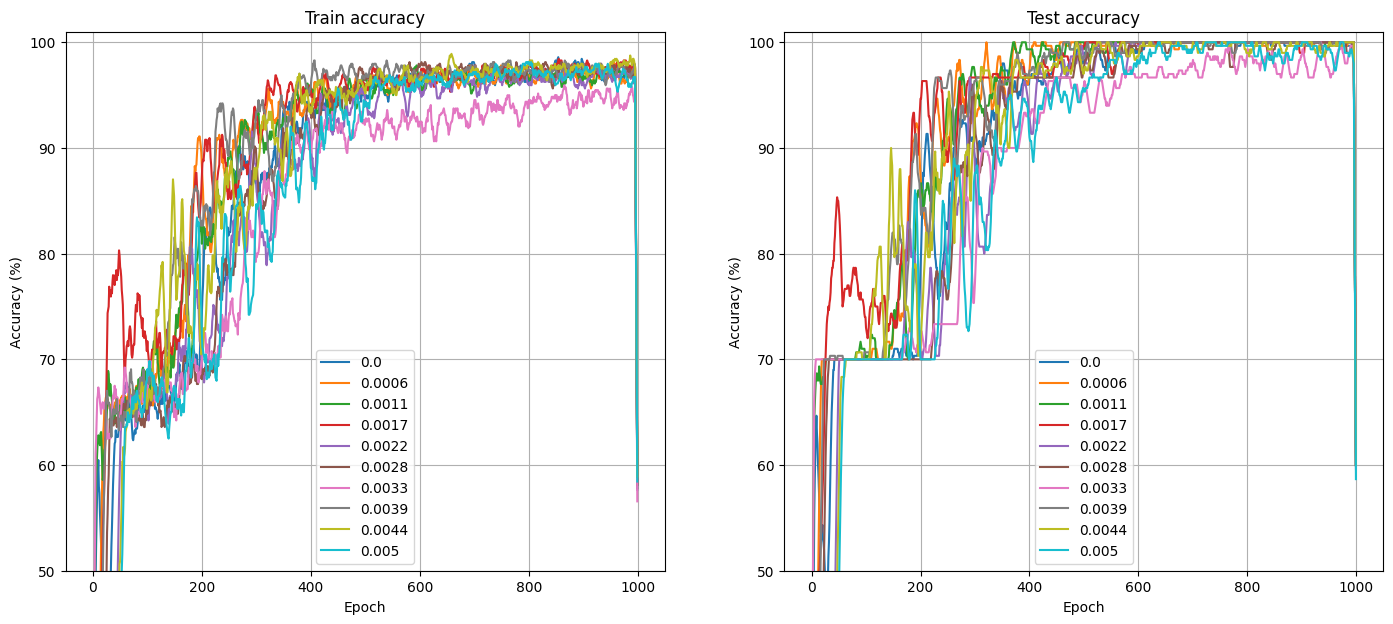

In [12]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,4) for i in L1lambda]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

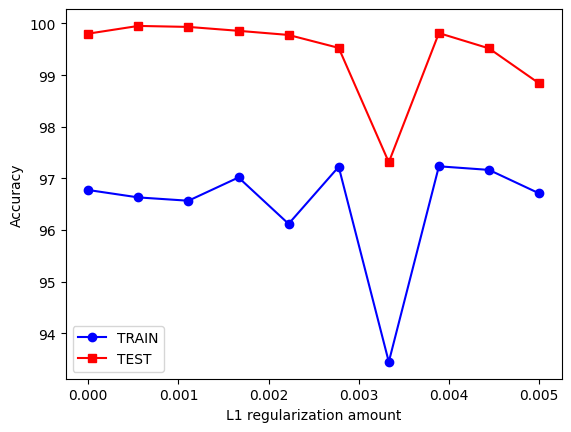

In [13]:
# show average accuracy by L1 rate
epoch_range = [500,950]

plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()